In [107]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

In [110]:
from jax.config import config
config.update("jax_enable_x64", True)

In [188]:
## import modules
import preconditioner as precond
import conjugate_gradient as cg
import pivoted_cholesky as pc
import pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
reload()

In [4]:
def generate_K(N, seed=0, noise=1e-06):
    """
    generate positive definite symmetric matrix
    """
    K = jax.random.normal(jax.random.PRNGKey(seed), (N, N))
    # K = K @ K.T + 30* jnp.eye(N) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) / N
    K = jnp.dot(K, K.T)/N
    # K += (noise+30)*jnp.eye(N) ## ??
    K += (5)*jnp.eye(N)
    K += (noise)*jnp.eye(N)
    if not is_positive_definite(K):
        raise Exception("K is not positive definite !")
    return K

In [5]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [16]:
def rel_error(true, pred):
    nonzero_index = jnp.where(true != 0.)
    true = true[nonzero_index]
    pred = pred[nonzero_index]
    return jnp.mean(jnp.abs((true-pred)/true))

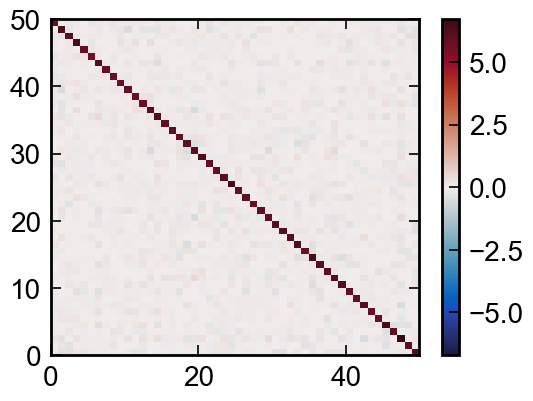

In [11]:
K = generate_K(50)
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [7]:
K = generate_K(100)
jnp.all(jnp.arange(100) == jnp.argmax(K, axis=1))

DeviceArray(True, dtype=bool)

In [8]:
is_positive_definite(K)

True

## 1. pivoted cholesky

In [12]:
import gpytorch
import torch

In [13]:
def test_pc(N, max_iter=5):
    K = np.array(generate_K(N))
    # L_ref = pc_ref.pivoted_cholesky_np_gpt(K, max_iter=max_iter)
    K_torch = torch.from_numpy(np.array(K))
    L_torch = gpytorch.pivoted_cholesky(K_torch, rank=max_iter)
    L_torch = L_torch.numpy()
    L = pc.pivoted_cholesky_numpy(K, max_iter=max_iter)
    return L, L_torch, np.mean(np.abs(L-L_torch))

In [14]:
L, L_torch, err = test_pc(5)
L, L_torch, err

(array([[-0.03554979, -0.11513225,  0.07102961,  2.33707125,  0.        ],
        [ 0.18466393, -0.14136497, -0.05103702,  0.0825544 ,  2.32611387],
        [ 0.07879127,  0.20885311,  2.35428871,  0.        ,  0.        ],
        [ 2.52619825,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.13368111,  2.44039874,  0.        ,  0.        ,  0.        ]]),
 array([[-0.03554979, -0.11513225,  0.07102961,  2.33707125,  0.        ],
        [ 0.18466393, -0.14136497, -0.05103702,  0.0825544 ,  2.32611387],
        [ 0.07879127,  0.20885311,  2.35428871,  0.        ,  0.        ],
        [ 2.52619825,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.13368111,  2.44039874,  0.        ,  0.        ,  0.        ]]),
 0.0)

In [17]:
rel_error(L,L_torch)

DeviceArray(0., dtype=float64)

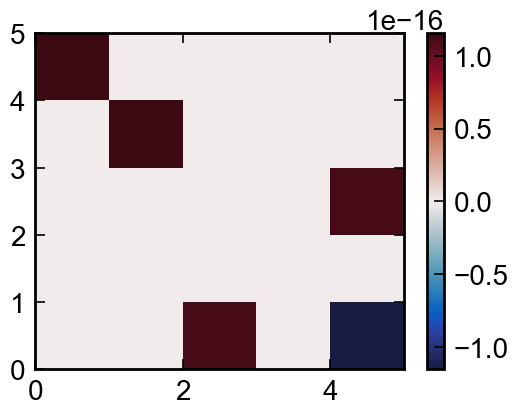

In [12]:
K = generate_K(5)
err_matrix = jnp.matmul(L_torch, L_torch.T)-K
fig, ax = plt.subplots()
abs_max = np.mean(np.abs(err_matrix))
mappable = ax.pcolormesh(np.flipud(err_matrix), vmin=-abs_max, vmax=abs_max, cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [13]:
L, L_torch, err = test_pc(15)
err

4.625929269271486e-20

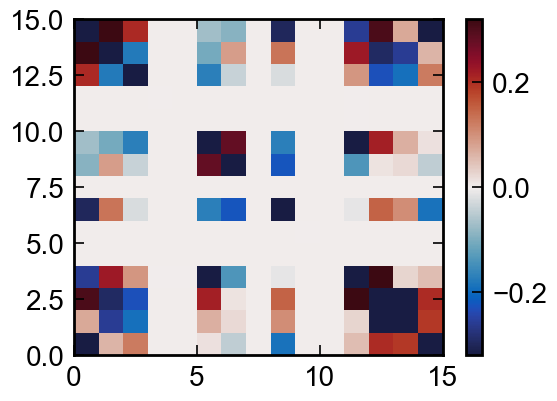

In [14]:
K = generate_K(15)
err_matrix = jnp.matmul(L_torch, L_torch.T)-K
fig, ax = plt.subplots()
abs_max = np.mean(np.abs(err_matrix))
mappable = ax.pcolormesh(np.flipud(err_matrix), vmin=-abs_max, vmax=abs_max, cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [15]:
L, L_torch, err = test_pc(100)
err

2.255140518769849e-20

In [16]:
L, L_torch, err = test_pc(10000)
err

1.9375455151968493e-22

## 1'. test of preconditioning

In [18]:
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

In [142]:
linear_operator.settings.cg_tolerance._set_value(1)
linear_operator.settings.cg_tolerance.value()

1

In [86]:
linear_operator.settings.max_preconditioner_size.value()

15

In [91]:
linear_operator.settings.max_cg_iterations.value()

1000

In [19]:
N = 4000
rank = 15
noise = 1e-06
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

In [20]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [21]:
# K_linear_op._preconditioner(), added_diag._preconditioner()

In [22]:
preconditioner_torch, _, _ = added_diag._preconditioner()

In [24]:
residual_precond_torch = preconditioner_torch(y_torch).numpy()

In [25]:
preconditioner = precond.Preconditioner(K, rank=rank, noise=noise)
residual_precond =preconditioner.precondition(y)

In [29]:
rel_error(residual_precond_torch[0], residual_precond)

DeviceArray(2.70684468e-16, dtype=float64)

In [30]:
N = 6000
rank = 15
noise = 1e-06
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

In [31]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N)*1e-06
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [32]:
preconditioner_torch, _, _ = added_diag._preconditioner()
residual_precond_torch = preconditioner_torch(y_torch).numpy()

preconditioner = precond.Preconditioner(K, rank=rank, noise=noise)
residual_precond =preconditioner.precondition(y)

In [33]:
rel_error(residual_precond_torch[0], residual_precond)

DeviceArray(2.6771701e-15, dtype=float64)

In [292]:
residual_precond, residual_precond_torch

(DeviceArray([  82579.9625053 ,  203803.8396463 ,  249047.96532672, ...,
               544362.89606171, 1234010.41831307,  427831.81151727],            dtype=float64),
 tensor([[  82579.9625,  203803.8396,  249047.9653,  ...,  544362.8961,
          1234010.4183,  427831.8115]], dtype=torch.float64))

### N=4000, 6000の場合において、preconditioner自体の働きはほとんど一致している

## 2. conjugate gradient (without precondition)

In [177]:
def test_u_cg(K, y, print_process=False, max_iter_cg=20):
    """
    comparison with jnp.linalg.solve
    """
    Kinvy_pcg = cg.cg_bbmm(K, y, preconditioner=None, print_process=True, max_iter_cg=max_iter_cg)
    Kinvy_ans = jnp.linalg.solve(K, y)
    print(f'mean rel error of $K^{-1}y$: {rel_error(Kinvy_ans, Kinvy_pcg )}')
    return Kinvy_pcg, Kinvy_ans

In [178]:
max_iter_cg = 1000

In [179]:
N = 5
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
u = cg.cg_bbmm(K, y, print_process=True)

j=0 r1norm: 0.13012937939025124
j=1 r1norm: 0.004918920057688955
j=2 r1norm: 3.203159586120873e-05
j=3 r1norm: 3.0481389196156853e-06
j=4 r1norm: 4.454545408927203e-20
j=5 r1norm: 1.939428388832863e-21
j=6 r1norm: 3.182068310920234e-23
j=7 r1norm: 4.276471932640352e-25
j=8 r1norm: 2.7676360496009777e-26
j=9 r1norm: 7.767861357139701e-39
j=10 r1norm: 5.863862397920137e-41
converged


In [180]:
np.mean(np.abs(u-jnp.linalg.solve(K, y)))

6.938893903907228e-18

In [181]:
N = 100
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
Kinvy, Kinvy_linalg = test_u_cg(K, y)

j=0 r1norm: 0.1611711514996197
j=1 r1norm: 0.02480829602988842
j=2 r1norm: 0.0034046129811756433
j=3 r1norm: 0.00046866626060455824
j=4 r1norm: 6.83006068451276e-05
j=5 r1norm: 9.88115883595946e-06
j=6 r1norm: 1.5301186182180347e-06
j=7 r1norm: 2.1984549726094885e-07
j=8 r1norm: 2.7727453436771526e-08
j=9 r1norm: 3.3850567679214583e-09
j=10 r1norm: 3.810917185686343e-10
converged
mean rel error of $K^-1y$: 1.7171776476550932e-09


In [ ]:
N = 10000
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))
Kinvy, Kinvy_linalg = test_u_cg(K, y)

#### gpytorchとの比較

In [182]:
N = 7000
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

In [183]:
Kinvy = cg.cg_bbmm(K, y, preconditioner=None, print_process=False, max_iter_cg=max_iter_cg)
Kinvy_linalg = jnp.linalg.solve(K, y)

K_linear_op = linear_operator.to_linear_operator(K_torch)
Kinvy_torch = K_linear_op.solve(y_torch)

In [184]:
%%timeit
Kinvy = cg.cg_bbmm(K, y, preconditioner=None, print_process=False, max_iter_cg=max_iter_cg)

66.4 ms ± 702 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [185]:
%%timeit
Kinvy_linalg = jnp.linalg.solve(K, y)

743 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [186]:
%%timeit
Kinvy_torch = K_linear_op.solve(y_torch)

209 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
print(rel_error(Kinvy_linalg, Kinvy))
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))

3.267805966209713e-09
7.14742692947957e-06


## 3. standard preconditioned conjugate gradient (pCG, Algorithm 1 in Appendix A.) 

consider linear problem that calculate $u=A^{-1}b$ given $A\in\mathbb{R}^{N\times N}, b\in\mathbb{R}^{N}$

In [189]:
def test_u_pcg(K, y,rank,noise, print_process=False, max_iter_cg=20):
    """
    comparison with jnp.linalg.solve
    """
    if rank is None:
        rank = A.shape[-1]
    preconditioner = precond.Preconditioner(K, rank, noise)
    u_pcg = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=True, max_iter_cg=max_iter_cg)
    u_ans = jnp.linalg.solve(K, y)
    print(f'mean rel error of u: {rel_error(u_ans, u_pcg)}')
    return u_pcg, u_ans

In [190]:
N = 5
rank=5
noise = 1e-06
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
preconditioner = precond.Preconditioner(K, rank=rank, noise=noise)
u_pcg = cg.cg_bbmm(K, y, print_process=True, tolerance=1e-03)
u_ans = jnp.linalg.solve(K, y)
np.mean(np.abs(u_pcg - u_ans))

j=0 r1norm: 0.13012937939025124
j=1 r1norm: 0.004918920057688955
j=2 r1norm: 3.203159586120873e-05
j=3 r1norm: 3.0481389196156853e-06
j=4 r1norm: 4.454545408927203e-20
j=5 r1norm: 1.939428388832863e-21
j=6 r1norm: 3.182068310920234e-23
j=7 r1norm: 4.276471932640352e-25
j=8 r1norm: 2.7676360496009777e-26
j=9 r1norm: 7.767861357139701e-39
j=10 r1norm: 5.863862397920137e-41
converged


6.938893903907228e-18

In [208]:
N = 3000
rank=15
noise = 1e-06
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
Kinvy, Kinvy_linalg = test_u_pcg(K, y, rank=rank, noise=noise)

j=0 r1norm: 0.18199535203114475
j=1 r1norm: 0.0714975352192756
j=2 r1norm: 0.06723412325866561
j=3 r1norm: 0.06713815881756245
j=4 r1norm: 0.06713709885968565
j=5 r1norm: 0.06713652036899474
j=6 r1norm: 0.06713636532775707
j=7 r1norm: 0.06713457348648401
j=8 r1norm: 0.067078923402247
j=9 r1norm: 0.06420814375758752
j=10 r1norm: 0.028771594866670313
converged
mean rel error of u: 0.12445402099758757


明らかに収束していない、rankが小さいと上手く行っていない

In [ ]:
N = 4000
rank=10000
noise = 1e-06
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

rankを増やせば上手く行くが計算時間が長くなるため意味がない

### gpytorchとの比較

In [193]:
N = 3000
rank = 15
noise = 1e-06
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

In [194]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [195]:
Kinvy_torch = added_diag.solve(y_torch)
Kinvy_linalg = jnp.linalg.solve(K, y)

In [204]:
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=True, max_iter_cg=max_iter_cg, tolerance=1)

j=0 r1norm: 0.18199535203114475
j=1 r1norm: 0.0714975352192756
j=2 r1norm: 0.06723412325866561
j=3 r1norm: 0.06713815881756245
j=4 r1norm: 0.06713709885968565
j=5 r1norm: 0.06713652036899474
j=6 r1norm: 0.06713636532775707
j=7 r1norm: 0.06713457348648401
j=8 r1norm: 0.067078923402247
j=9 r1norm: 0.06420814375758752
j=10 r1norm: 0.028771594866670313
converged


In [205]:
rel_error(Kinvy_linalg, Kinvy_torch.numpy())

DeviceArray(0.1244539, dtype=float64)

In [206]:
rel_error(Kinvy_linalg, Kinvy)

DeviceArray(0.12445402, dtype=float64)

#### gpytorchと一致した、!

### tol=1e-02

In [209]:
linear_operator.settings.cg_tolerance._set_value(1e-02)
Kinvy_torch = added_diag.solve(y_torch)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

0.02420159374519818


In [215]:
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg, tolerance=1e-02)
print(rel_error(Kinvy_linalg, Kinvy))

0.0242016595731959


### tol=1e-04

In [216]:
linear_operator.settings.cg_tolerance._set_value(1e-04)
Kinvy_torch = added_diag.solve(y_torch)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

5.9155622409193994e-05


In [217]:
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg, tolerance=1e-04)
print(rel_error(Kinvy_linalg, Kinvy))

5.9171339196640115e-05


### checking time (tol=1)

In [242]:
N = 7000
rank = 15
noise = 1e-06
K = generate_K(N)
K_torch = torch.from_numpy(np.array(K))
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y_torch = torch.from_numpy(np.array(y))

In [243]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [254]:
Kinvy_torch = added_diag.solve(y_torch)
Kinvy_linalg = jnp.linalg.solve(K, y)
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg, tolerance=1)

In [255]:
%%timeit
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg)

240 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [246]:
%%timeit
Kinvy_torch = added_diag.solve(y_torch)

271 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [247]:
%%timeit
Kinvy_linalg = jnp.linalg.solve(K, y)

745 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [248]:
print(rel_error(Kinvy_linalg, Kinvy))
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))

0.09073120214639631
6.251287851354988e-05


### checking time (tol=1e-4)

In [249]:
tol=1e-04
linear_operator.settings.cg_tolerance._set_value(tol)
Kinvy_torch = added_diag.solve(y_torch)
Kinvy_linalg = jnp.linalg.solve(K, y)
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg, tolerance=tol)

In [250]:
%%timeit
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg)

239 ms ± 6.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [251]:
%%timeit
Kinvy_torch = added_diag.solve(y_torch)

274 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [257]:
%%timeit
Kinvy_linalg = jnp.linalg.solve(K, y)

2.03 s ± 442 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [253]:
print(rel_error(Kinvy_linalg, Kinvy))
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

6.252892798062163e-05
6.251287851354988e-05


### comparison between precondition and not

In [256]:
N = 10000
rank = 15
noise = 1e-06
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))

In [269]:
Kinvy = cg.cg_bbmm(K, y, preconditioner=None, print_process=False, max_iter_cg=max_iter_cg)
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy_precond = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg)

In [263]:
%%timeit
Kinvy = cg.cg_bbmm(K, y, preconditioner=None, print_process=False, max_iter_cg=max_iter_cg)

75.6 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [264]:
%%timeit
preconditioner = precond.Preconditioner(K, rank, noise)
Kinvy_precond = cg.cg_bbmm(K, y, preconditioner=preconditioner, print_process=False, max_iter_cg=max_iter_cg)

261 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [270]:
Kinvy_linalg = jnp.linalg.solve(K, y)

In [271]:
print(rel_error(Kinvy_linalg, Kinvy))
print(rel_error(Kinvy_linalg, Kinvy_precond))

3.217495045498408e-09
0.07984550384547541


### around N=10000, wihtout preconditioning seems faster, but comparisoin should be done

# NO USE

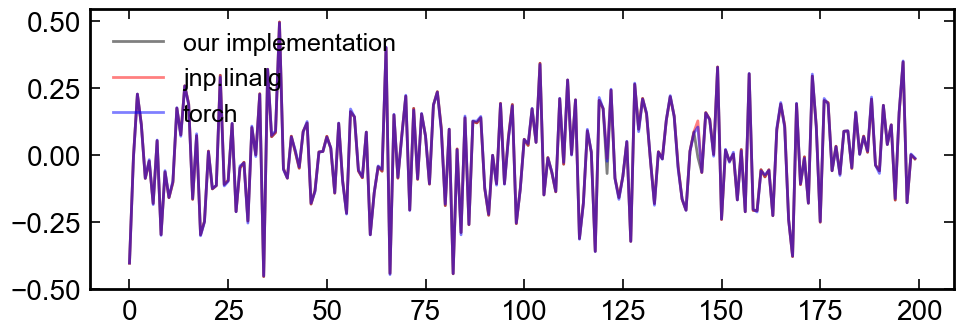

In [146]:
num=200
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(Kinvy[:num], label='our implementation', alpha=0.5)
ax.plot(Kinvy_linalg[:num], label='jnp.linalg', alpha=0.5)
ax.plot(Kinvy_torch[:num], label='torch', alpha=0.5)
plt.legend()

In [272]:
A = jnp.array([
    [0.1, 0., 0.01],
    [0., 0.2, 0.01],
    [0.01, 0.01, 0.3]
])
A += jnp.eye(len(A)) * noise
b = jnp.array([0.1, 0.1, 0.1])

In [273]:
preconditioner = precond.Preconditioner(A, rank=3, noise=noise)

In [274]:
print(cg.pcg_bbmm(A, b, preconditioner))
print(calculate_yKy_naive(A, b))

[0.971512   0.48576086 0.28475809]
[0.97151463 0.48575974 0.28475657]


In [228]:
test_u_pcg(A, b, rank=3, noise=noise)

j=0 r1norm: 5.574751958270594e-07
converged
mean error of u: 1.7523094279122315e-06


#### $N=1000$

In [261]:
N = 1000
K = jnp.array(generate_K(N))
b = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
x = jnp.zeros_like(b)

In [262]:
test_u_pcg(K, b, rank=5, noise=noise, print_process=True)

j=0 r1norm: 30.756275092600895
j=1 r1norm: 29.778074765094793
j=2 r1norm: 26.692398953580707
j=3 r1norm: 24.425435407610305
j=4 r1norm: 21.346737010196513
j=5 r1norm: 19.20159525190699
j=6 r1norm: 16.01735263296142
j=7 r1norm: 14.282045447136174
j=8 r1norm: 12.133736243177383
j=9 r1norm: 9.986568635473414
j=10 r1norm: 8.432404291931604
j=11 r1norm: 7.07016490801187
j=12 r1norm: 6.108472011833951
j=13 r1norm: 5.461384489715984
j=14 r1norm: 4.736899939151051
j=15 r1norm: 4.211603347672603
j=16 r1norm: 3.8030798265092494
j=17 r1norm: 3.5422100996989765
j=18 r1norm: 3.267597289806469
j=19 r1norm: 3.0222948324128303
mean error of u: 0.00028883736267989015


#### $N=10000$

In [264]:
N = 10000
K = jnp.array(generate_K(N))
b = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
x = jnp.zeros_like(b)

In [265]:
test_u_pcg(K, b, rank=5, noise=noise, print_process=True)

j=0 r1norm: 101.4652043596573
j=1 r1norm: 99.45879757260212
j=2 r1norm: 98.87072313991212
j=3 r1norm: 97.6356602317213
j=4 r1norm: 97.39995769383573
j=5 r1norm: 96.67718897212345
j=6 r1norm: 96.32439435363506
j=7 r1norm: 93.91435619048809
j=8 r1norm: 91.14978413276249
j=9 r1norm: 88.4728158433921
j=10 r1norm: 86.96141782953181
j=11 r1norm: 84.90474917540834
j=12 r1norm: 82.28939600169107
j=13 r1norm: 78.43891389056382
j=14 r1norm: 73.0877718191923
j=15 r1norm: 69.92929208866838
j=16 r1norm: 67.37632780767137
j=17 r1norm: 64.03546381393818
j=18 r1norm: 61.09100180827336
j=19 r1norm: 58.935910659751016
mean error of u: 0.0021385223058978404


In [268]:
def bbmm(K, b):
    preconditioner = precond.Preconditioner(K, rank=5, noise=1e-06)
    return jnp.dot(b.T, cg.pcg_bbmm(K, b, preconditioner, max_iter_cg=20))
def naive(K, b):
    return jnp.dot(b.T,jnp.linalg.solve(K, b))
def cholesky(K, b):
    v = jnp.linalg.solve(jnp.linalg.cholesky(K), b)
    return jnp.dot(v, v) 

In [269]:
bbmm(K, b), naive(K, b)

(Array(15.01664495, dtype=float64), Array(18.56682135, dtype=float64))

## なぜか対角成分に大きな値を足さないと上手く計算できない?→zero divisionが原因かもしれない
- 判定基準にも問題がある可能性はある?←実際に得られたyKyも一致していないから、収束条件のミスではない、単純に計算が上手く行っていない
